--------------- Import Libraries ---------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

--------------- Load Dataset ---------------

In [2]:
os.chdir("C:/Users/Jose Guevara/Desktop/GitHub_Clones/challenges/main/Churn")

In [3]:
# Load the dataset
file_path = 'customer_churn_dataset-training-master.csv'  # Replace with the correct path
df = pd.read_csv(file_path)

# Set CustomerID as index
df.set_index('CustomerID', inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440833 entries, 2.0 to 449999.0
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  float64
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  float64
 3   Usage Frequency    440832 non-null  float64
 4   Support Calls      440832 non-null  float64
 5   Payment Delay      440832 non-null  float64
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  float64
 10  Churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 40.4+ MB


In [5]:
df.isnull().sum()

Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
print(df.columns)
print(df.head())

Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend',
       'Last Interaction', 'Churn'],
      dtype='object')
             Age  Gender  Tenure  Usage Frequency  Support Calls  \
CustomerID                                                         
2.0         30.0  Female    39.0             14.0            5.0   
3.0         65.0  Female    49.0              1.0           10.0   
4.0         55.0  Female    14.0              4.0            6.0   
5.0         58.0    Male    38.0             21.0            7.0   
6.0         23.0    Male    32.0             20.0            5.0   

            Payment Delay Subscription Type Contract Length  Total Spend  \
CustomerID                                                                 
2.0                  18.0          Standard          Annual        932.0   
3.0                   8.0             Basic         Monthly        557.0   
4.0        

------------- Exploratory Data Analysis (EDA) ---------------

In [8]:
df['Churn'].value_counts()

Churn
1.0    249999
0.0    190833
Name: count, dtype: int64

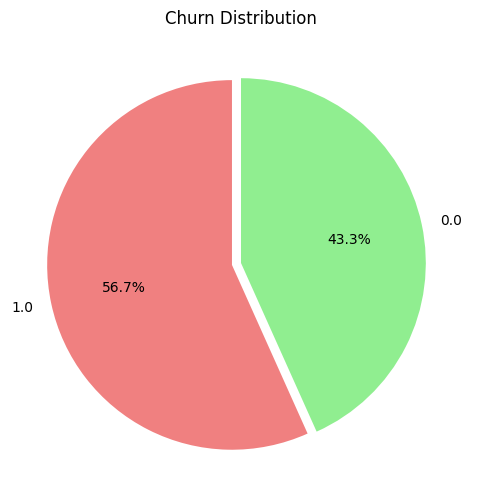

In [9]:
# Assuming y is the target variable (Churn)
# Plotting the pie chart for the response variable
plt.figure(figsize=(6, 6))
df['Churn'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'], startangle=90, explode=[0.05, 0])
plt.title('Churn Distribution')
plt.ylabel('')  # Remove the y-label to make it cleaner
plt.show()

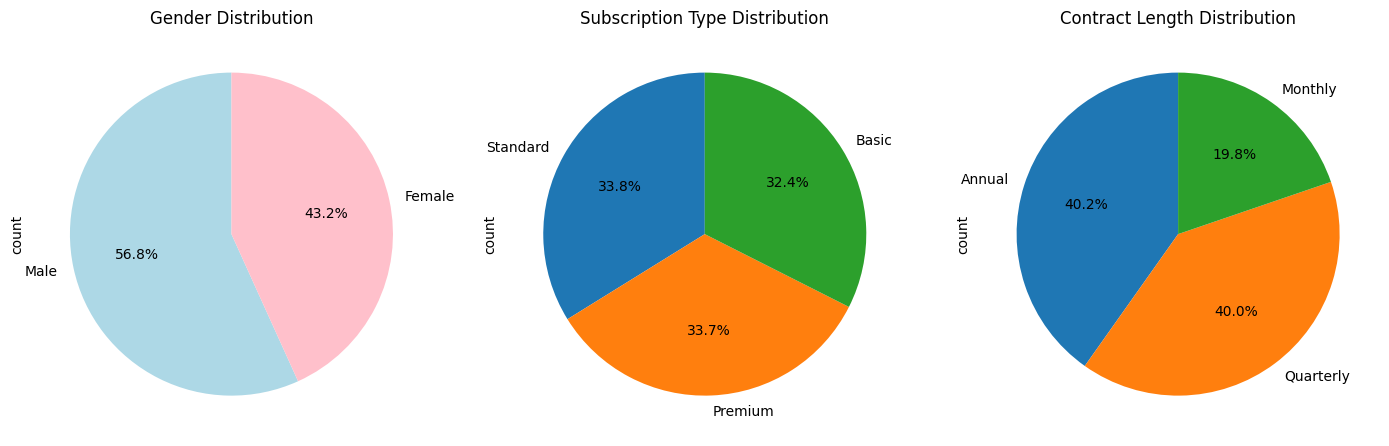

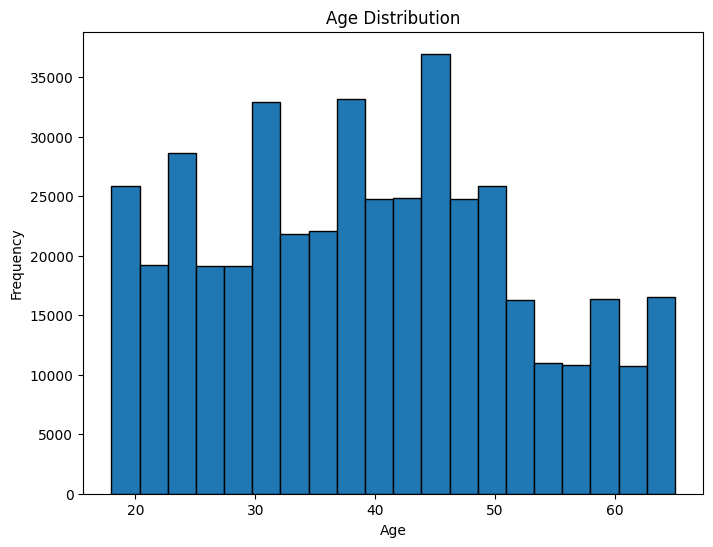

<Figure size 1400x600 with 0 Axes>

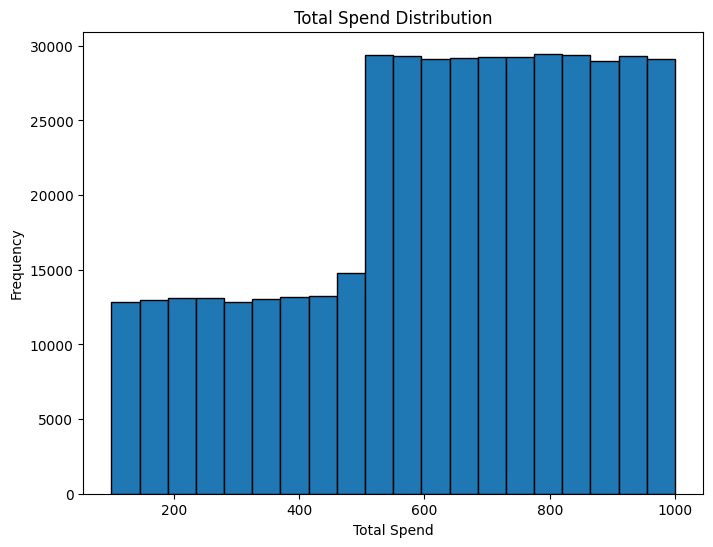

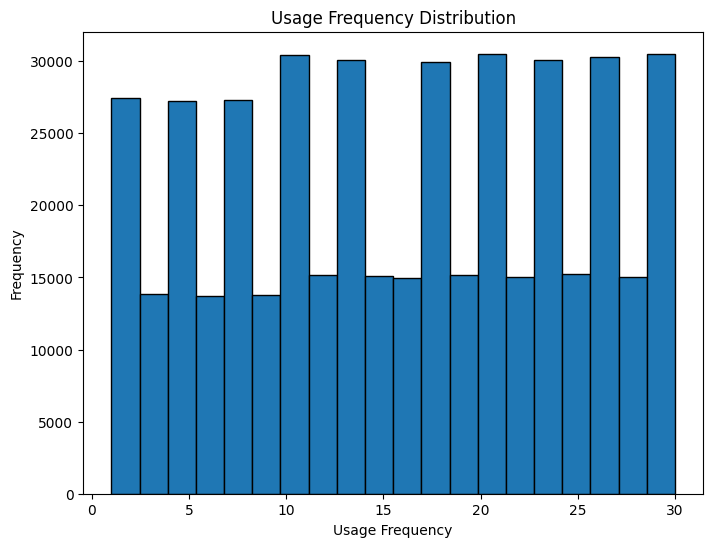

<Figure size 640x480 with 0 Axes>

In [10]:
# Pie chart for Gender, Subscription Type, and Contract Length
plt.figure(figsize=(14, 8))

# Gender Pie Chart
plt.subplot(1, 3, 1)
df['Gender'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue', 'pink'], startangle=90)
plt.title('Gender Distribution')

# Subscription Type Pie Chart
plt.subplot(1, 3, 2)
df['Subscription Type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Subscription Type Distribution')

# Contract Length Pie Chart
plt.subplot(1, 3, 3)
df['Contract Length'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Contract Length Distribution')

plt.tight_layout()
plt.show()

# Histogram for Age
plt.figure(figsize=(8, 6))
df['Age'].plot.hist(bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

# Bar plot for Total Spend and Usage Frequency
plt.figure(figsize=(14, 6))

# Total Spend Histogram plot
plt.figure(figsize=(8, 6))
df['Total Spend'].plot.hist(bins=20, edgecolor='black')
plt.title('Total Spend Distribution')
plt.xlabel('Total Spend')
plt.show()

# Usage Frequency Bar plot
plt.figure(figsize=(8, 6))
df['Usage Frequency'].plot.hist(bins=20, edgecolor='black')
plt.title('Usage Frequency Distribution')
plt.xlabel('Usage Frequency')
plt.show()

plt.tight_layout()
plt.show()

------------- Seaborn Pairplot for Numeric Variables ---------------

In [11]:
# Select numeric variables only
numeric_df = df[['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']]
numeric_df = numeric_df.apply(pd.to_numeric, errors = 'coerce')
# Check for missing values in the numeric columns
print("Missing values in numeric columns:\n", numeric_df.isnull().sum())

Missing values in numeric columns:
 Age                 0
Tenure              0
Usage Frequency     0
Support Calls       0
Payment Delay       0
Total Spend         0
Last Interaction    0
dtype: int64


In [12]:
print(np.isfinite(numeric_df).all())

Age                 True
Tenure              True
Usage Frequency     True
Support Calls       True
Payment Delay       True
Total Spend         True
Last Interaction    True
dtype: bool


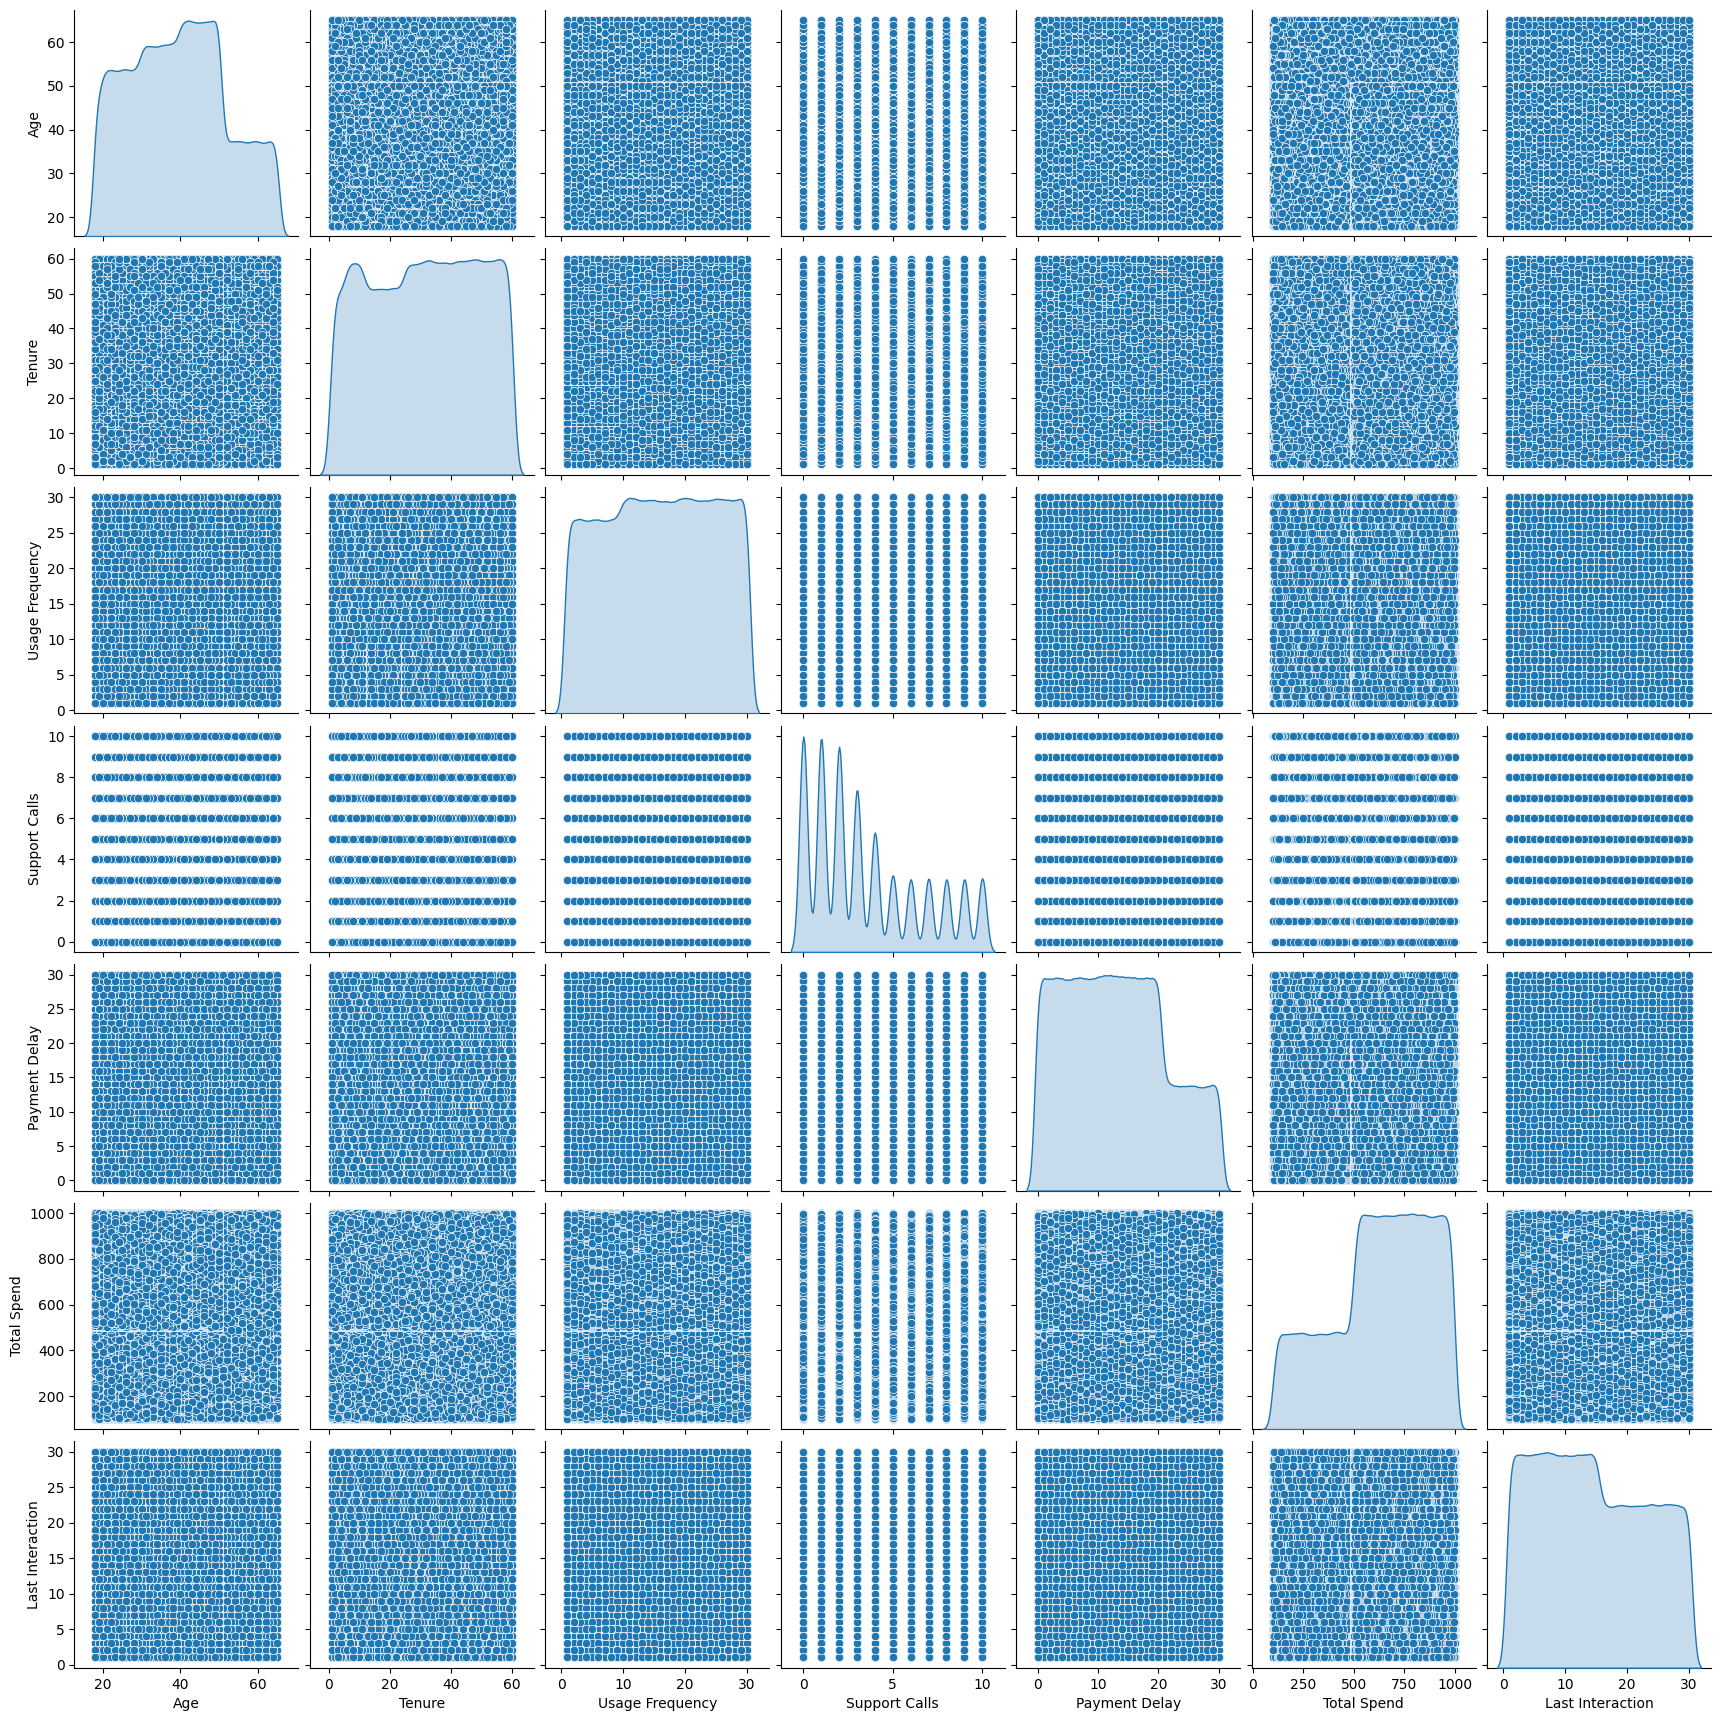

In [13]:
# Seaborn pairplot
sns.pairplot(numeric_df, diag_kind='kde')

------------- Machine Learning with XGBoost ---------------

In [14]:
# Define the features and target variable
X = df[['Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction']]
y = df['Churn']

In [15]:
# Define categorical and numeric columns
categorical_columns = ['Gender', 'Subscription Type', 'Contract Length']
numeric_columns = ['Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']

# Use OneHotEncoder for categorical columns and leave numeric columns as is
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),  # drop='first' avoids multicollinearity, but usually used in CV
        ('num', 'passthrough', numeric_columns)
    ])

In [16]:
# Transform the data
X_transformed = preprocessor.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

In [17]:
# Initialize the XGBoost classifier with GPU support
xgb_model = XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, eval_metric='mlogloss')

# Set up the hyperparameter grid for fine-tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [18]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:  {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}


--------------- Predicting on the test set ---------------

In [19]:
# Predicting on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Display classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     57160
         1.0       0.99      0.96      0.98     75090

    accuracy                           0.98    132250
   macro avg       0.97      0.98      0.98    132250
weighted avg       0.98      0.98      0.98    132250



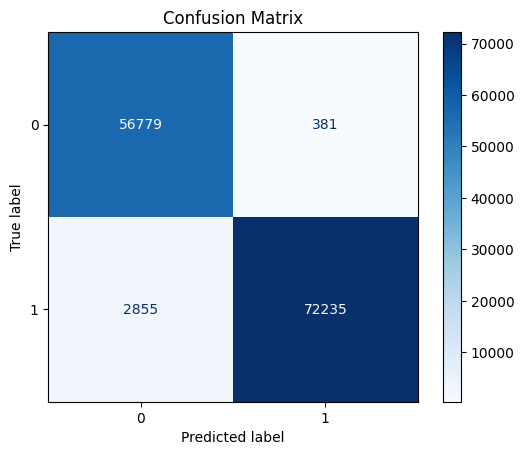

Sensitivity: 0.9620
Specificity: 0.9933


In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Calculate Sensitivity, Specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

In [21]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

In [22]:
# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

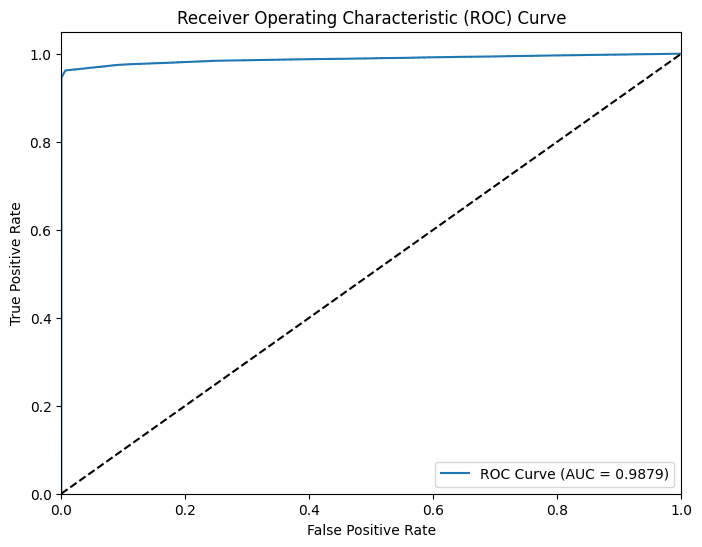

In [23]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random predictions
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

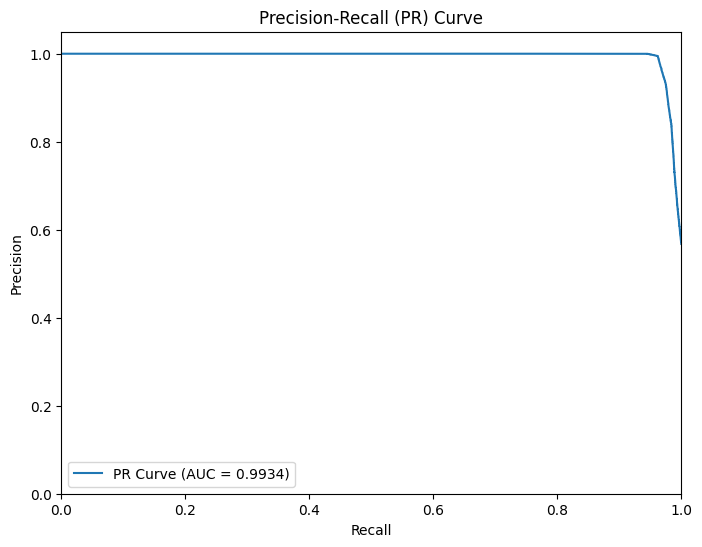

In [24]:
# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.4f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc="lower left")
plt.show()

--------------- Saving the Model ---------------

In [25]:
import joblib

In [26]:
# Save the trained model as a .pkl file
model_filename = 'xgboost_churn_model.pkl'
joblib.dump(grid_search.best_estimator_, model_filename)

print(f"Model saved as {model_filename}")

Model saved as xgboost_churn_model.pkl


------------------- SHAP Values for XGBoost Model --------------------

In [27]:
import shap

In [28]:
# Convert X_train back to DataFrame with appropriate column names after transformation
X_train_df = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())

In [29]:
X_display = X_test  # Use the test set features for SHAP visualization
y_display = y_test     # Use the actual labels of the test set


In [30]:
explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


------------------- SHAP Feature Importance Plot --------------------

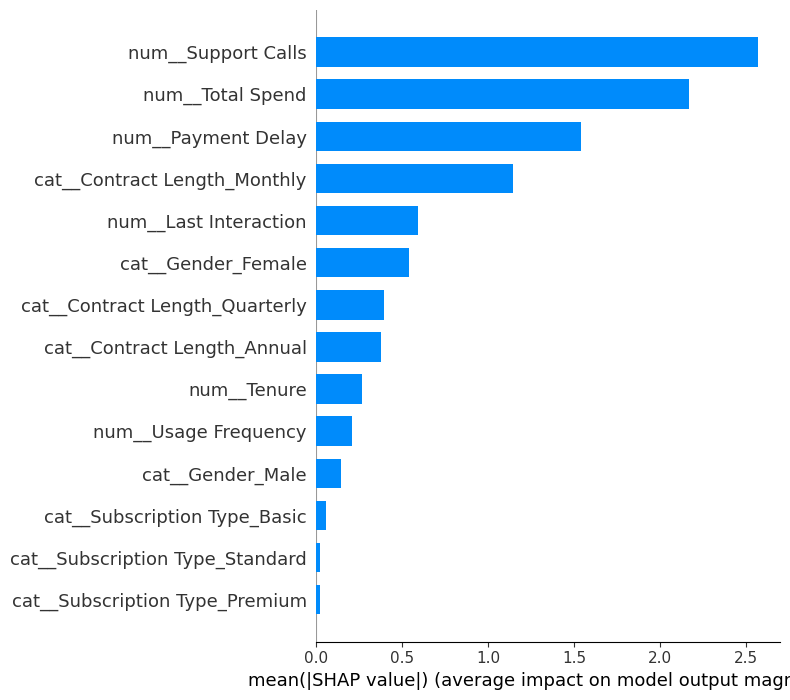

In [31]:
# Bar plot of feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=preprocessor.get_feature_names_out())
plt.show()

------------------- SHAP Dependence Plot for a Specific Feature --------------------

In [32]:
# Initialize the SHAP JavaScript visualizations
shap.initjs()

In [33]:
shap.force_plot(explainer.expected_value, shap_values[:2000, :], X_train_df.iloc[:2000, :])